In [ ]:
import pandas as pd
import numpy as np

import math
from datetime import datetime,timedelta

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss,acf,pacf
from sklearn.preprocessing import MinMaxScaler

# Plot library
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
'''     Jena Climate dataset is made up of 14 different quantities
    (such air temperature, atmospheric pressure, humidity, wind direction, and so on)
    were recorded every 10 minutes,  over several years.
    This dataset covers data from January 1st 2009 to December 31st 2016. '''

'     Jena Climate dataset is made up of 14 different quantities\n    (such air temperature, atmospheric pressure, humidity, wind direction, and so on)\n    were recorded every 10 minutes,  over several years.\n    This dataset covers data from January 1st 2009 to December 31st 2016. '

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
climate = pd.read_csv('jena_climate_2009_2016.csv')
climate.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
climate.rename(columns={"T (degC)": "Temp"}, inplace=True)

In [ ]:
import pandas as pd

# Assuming your DataFrame is named df
climate.rename(columns={"Date Time": "DateTime"}, inplace=True)

# Handling Missing values

In [ ]:
def missing_col(df):
    missing_values = climate.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)

    return missing_values

missing_columns = missing_col(climate)
print(missing_columns)

DateTime           0
p (mbar)           0
Temp               0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [ ]:
def df_info_(df):
    """
        Information about the DataFrame
    """

    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_cols = missing_col(df)
    features_names = missing_cols.index.values
    missing_values = missing_cols.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                       'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_cols),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)

In [ ]:
df_info_(climate)

===> This data frame contains 420551 rows and 15 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
DateTime        object         0-nan %              01.01.2009 00:10:00,01.01.2009 00:20:00,01.01.2009 00:30:00,01.01.2009 00:40:00,01.01.2009 00:50:00,==================================================
p (mbar)        float64        0-nan %              996.52,996.57,996.53,996.51,996.51,==================================================
Temp            float64        0-nan %              -8.02,-8.41,-8.51,-8.31,-8.27,==================================================
Tpot (K)        float64        0-nan %              265.4,265.01,264.91,265.12,265.15,==================================================
Tdew (degC)     float64        0-nan %              -8.9,-9.28,-9.31,-9.07,-9.04,==================================================
rh (%)          float64        0-nan %              93.3,93.4,93.9,94.2,94.1,=============================================

# Changing to DaTe-Time format

In [ ]:
climate['DateTime'] = pd.to_datetime(climate['DateTime'], format = "%d.%m.%Y %H:%M:%S" ) #change date time format
climate['Year'] = climate['DateTime'].dt.year
climate['Month'] = climate['DateTime'].dt.month

climate = climate.drop_duplicates().reset_index(drop = True)   # drop duplicates

In [ ]:
climate.columns

Index(['DateTime', 'p (mbar)', 'Temp', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'Year', 'Month'],
      dtype='object')

In [ ]:
climate.head()

,DateTime,p (mbar),Temp,Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Year,Month
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,2009,1
1,2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,2009,1
2,2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,2009,1
3,2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,2009,1
4,2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,2009,1


# Data Visulization

In [ ]:
view = climate.copy(deep = True)
view.describe()

,DateTime,p (mbar),Temp,Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Year,Month
count,420224,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000,420224.000000
mean,2012-12-30 09:17:41.471024640,989.214157,9.442421,283.484880,4.953472,76.028738,13.568642,9.532333,4.036225,6.021503,9.638778,1216.097805,1.700930,3.054884,174.748064,2012.497013,6.518673
min,2009-01-01 00:10:00,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000,2009.000000,1.000000
25%,2010-12-31 13:47:30,984.200000,3.360000,277.430000,0.230000,65.240000,7.770000,6.210000,0.870000,3.920000,6.280000,1187.540000,0.990000,1.760000,124.900000,2010.000000,4.000000
50%,2012-12-30 03:05:00,989.580000,9.400000,283.460000,5.210000,79.300000,11.810000,8.860000,2.180000,5.590000,8.960000,1213.830000,1.760000,2.960000,198.100000,2012.000000,7.000000
75%,2014-12-30 08:32:30,994.730000,15.460000,289.520000,10.070000,89.400000,17.590000,12.350000,5.290000,7.800000,12.480000,1242.790000,2.860000,4.730000,234.100000,2014.000000,10.000000
max,2017-01-01 00:00:00,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000,2017.000000,12.000000
std,NaN,8.360888,8.421135,8.502206,6.731171,16.460467,7.734770,4.183996,4.891287,2.656043,4.235244,39.967936,65.472111,69.043660,86.685323,2.289969,3.448870


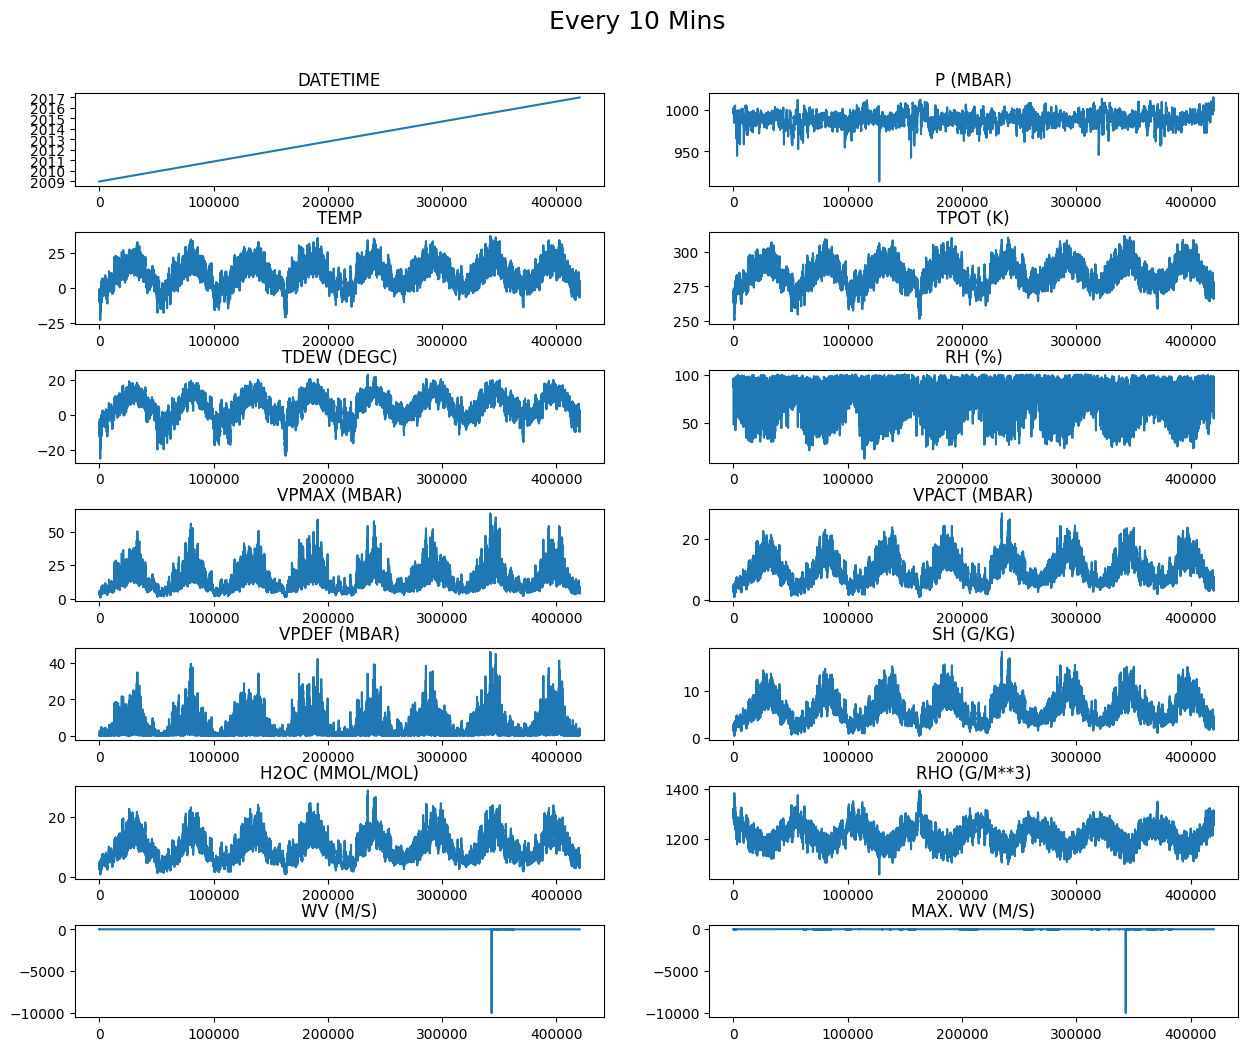

In [ ]:
target = ['Year','Month','Date Time']
used_cols = [c for c in view.columns.to_list() if c not in target]
lens = len(used_cols)

fig,axs = plt.subplots(nrows = 7, ncols = 2, figsize = (15,12))
plt.subplots_adjust(hspace = 0.5)
fig.suptitle('Every 10 Mins', fontsize = 18, y = 0.95)

for col, ax in zip(used_cols,axs.ravel()):
    view[col].plot(ax = ax)

    # chart formatting
    ax.set_title(col.upper())

    ax.set_xlabel("")

plt.show()

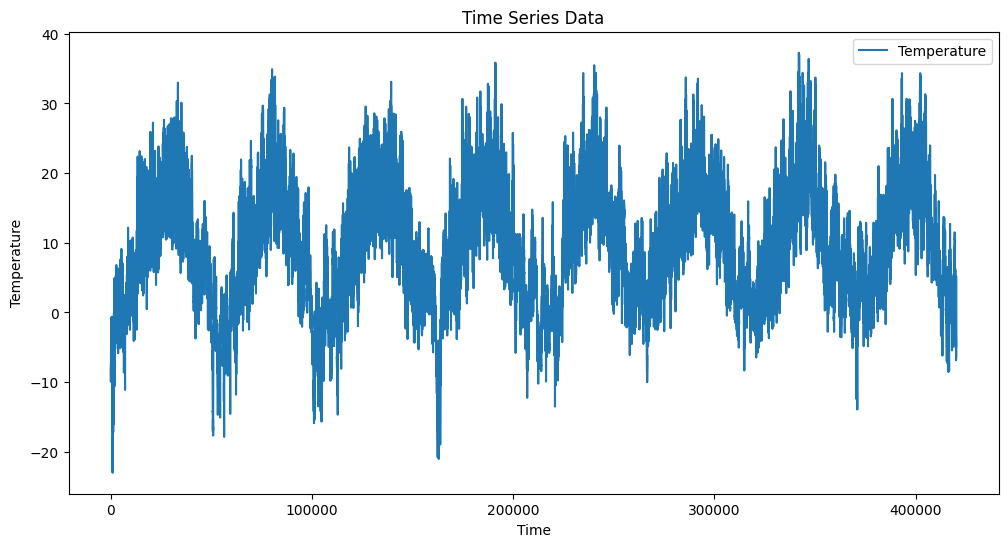

In [ ]:
# Data Visualization
plt.figure(figsize=(12, 6))
plt.plot(climate['Temp'], label='Temperature')
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Converting Date-Time column to Date-Time format

In [ ]:
import pandas as pd

# Assuming 'climate' DataFrame already exists and is correctly formatted
# Convert 'Date Time' to datetime and set as index if not already done
climate['DateTime'] = pd.to_datetime(climate['DateTime'], format="%d.%m.%Y %H:%M:%S")
climate.set_index('DateTime', inplace=True)

# Resample to daily data
climate_daily = climate.resample('D').median()

# Fill missing values if necessary
climate_daily = climate_daily.fillna(method='ffill')

# Reset index if desired
climate_daily = climate_daily.reset_index()

# Display the first few rows of the downscaled daily data
print(climate_daily.head())


    DateTime  p (mbar)   Temp  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0 2009-01-01   999.830 -6.870   266.270       -8.160    90.6         3.640   
1 2009-01-02   998.880 -3.930   269.320       -4.895    92.3         4.560   
2 2009-01-03   999.140 -5.175   267.935       -8.855    81.2         4.150   
3 2009-01-04   988.985 -1.440   272.800       -2.660    90.3         5.500   
4 2009-01-05   990.400 -3.640   270.265       -5.505    88.0         4.665   

   VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  rho (g/m**3)  \
0          3.30         0.350      2.050             3.30       1305.97   
1          4.24         0.360      2.650             4.25       1291.11   
2          3.12         0.725      1.945             3.12       1299.77   
3          5.02         0.530      3.170             5.08       1263.37   
4          4.05         0.555      2.545             4.09       1278.14   

   wv (m/s)  max. wv (m/s)  wd (deg)    Year  Month  
0     0.580           1.00

In [ ]:
target = 'Temp'

In [ ]:
time='DateTime'

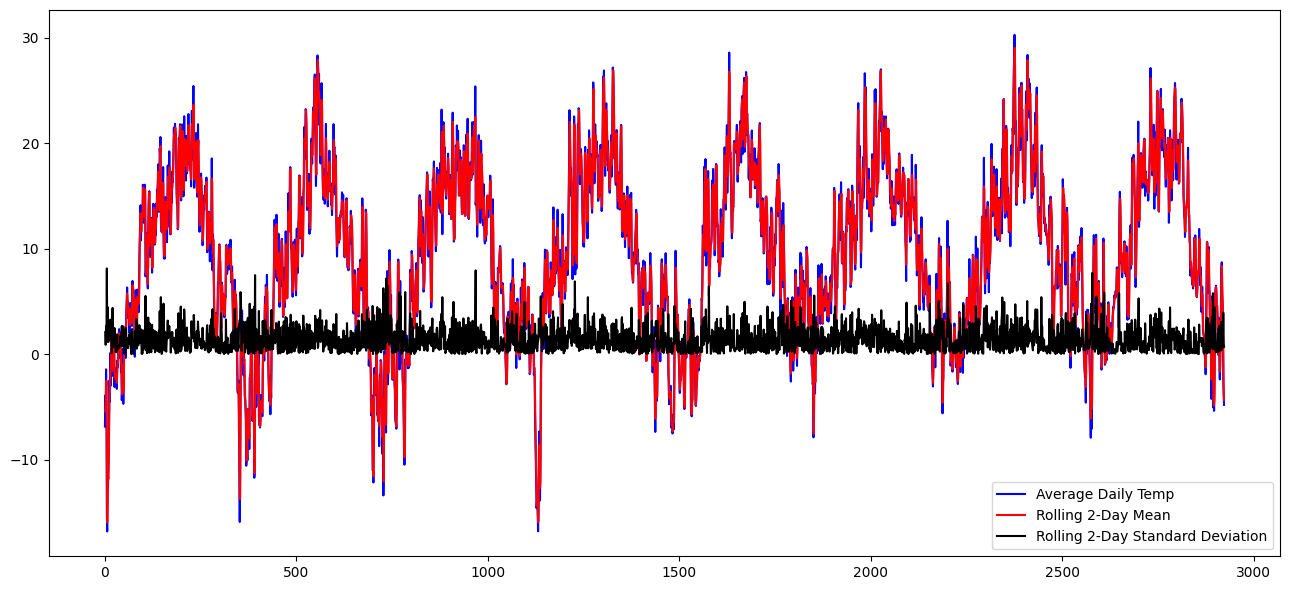

In [ ]:
# To observe 2-day rolling mean and std
roll_mean = climate_daily[target].rolling(window = 2, center = False).mean()
roll_std = climate_daily[target].rolling(window = 2, center = False).std()

fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(climate_daily[target], color='blue',label='Average Daily Temp')
ax.plot(roll_mean, color='red', label='Rolling 2-Day Mean')
ax.plot(roll_std, color='black', label='Rolling 2-Day Standard Deviation')
ax.legend()
fig.tight_layout()

# Stationarity

In [ ]:
#To check its stationarity
#df = climate.copy(deep = True)
#df.set_index('Date Time', inplace=True, drop=False)

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print('-' * 30)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(climate_daily[target])
print(climate_daily[target])

Results of Dickey-Fuller Test:
------------------------------
Test Statistic                   -3.578233
p-value                           0.006191
#Lags Used                       18.000000
Number of Observations Used    2904.000000
Critical Value (1%)              -3.432604
Critical Value (5%)              -2.862536
Critical Value (10%)             -2.567300
dtype: float64
0      -6.870
1      -3.930
2      -5.175
3      -1.440
4      -3.640
        ...  
2918    4.950
2919    3.165
2920   -2.390
2921   -3.845
2922   -4.820
Name: Temp, Length: 2923, dtype: float64


In [ ]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

kpss_test(climate_daily[target])

Results of KPSS Test:
Test Statistic            0.19723
p-value                   0.10000
#Lags Used               31.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


<ipython-input-27-e639e1b5e764>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags="auto")


# Checking For Seasonality

<Figure size 1200x600 with 0 Axes>

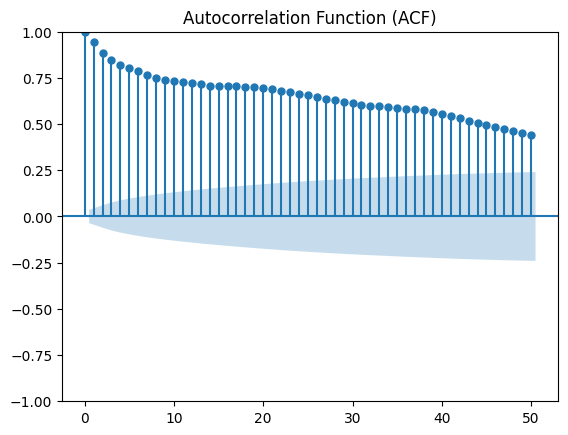

<Figure size 1200x600 with 0 Axes>

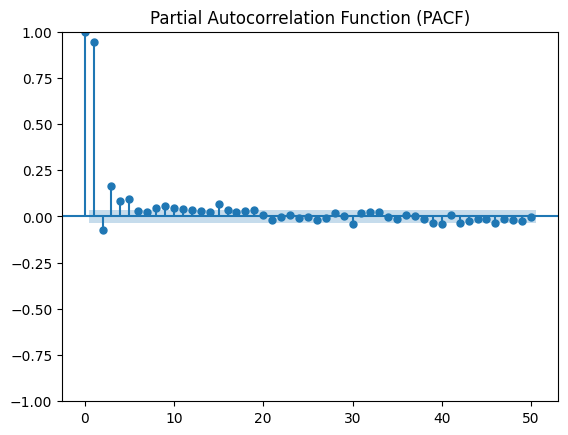

In [ ]:
# Check for Seasonality using Autocorrelation Plots
plt.figure(figsize=(12, 6))
plot_acf(climate_daily['Temp'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(climate_daily['Temp'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:

from sklearn.preprocessing import MinMaxScaler
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(climate_daily[['Temp']])

# Apply scaling to the entire dataset before splitting
climate_daily['Scaled_Temp'] = scaled_temp

# Selecting features and target variable after scaling
X = climate_daily[['Scaled_Temp', 'Year', 'Month']]
y = climate_daily['Scaled_Temp']


In [ ]:
climate_daily.head()

,p (mbar),Temp,Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),Year,Month
DateTime,,,,,,,,,,,,,,,,
2009-01-01,999.830,-6.870,266.270,-8.160,90.6,3.640,3.30,0.350,2.050,3.30,1305.97,0.580,1.00,168.500,2009,1
2009-01-02,998.880,-3.930,269.320,-4.895,92.3,4.560,4.24,0.360,2.650,4.25,1291.11,1.215,1.94,142.050,2009,1
2009-01-03,999.140,-5.175,267.935,-8.855,81.2,4.150,3.12,0.725,1.945,3.12,1299.77,1.185,2.13,199.700,2009,1
2009-01-04,988.985,-1.440,272.800,-2.660,90.3,5.500,5.02,0.530,3.170,5.08,1263.37,1.515,3.38,223.500,2009,1
2009-01-05,990.400,-3.640,270.265,-5.505,88.0,4.665,4.05,0.555,2.545,4.09,1278.14,3.085,5.13,26.695,2009,1


In [ ]:

from sklearn.preprocessing import MinMaxScaler
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_temp = scaler.fit_transform(climate_daily[['Temp']])

# Apply scaling to the entire dataset before splitting
climate_daily['Scaled_Temp'] = scaled_temp

# Selecting features and target variable after scaling
X = climate_daily[['Scaled_Temp', 'Year', 'Month']]
y = climate_daily['Scaled_Temp']


# Preparing Data-set for training the model by making small dataframes of existing Dataset

In [ ]:
import pandas as pd
import numpy as np

# Assuming climate is your original DataFrame with a datetime index and a 'Temp' column
# Downsample the data to daily frequency
climate_daily = climate.resample('D').median()

# Parameters
input_length = 20  # Number of past days
output_length = 10  # Number of forecast days

# Create sequences
def create_sequences(data, input_length, output_length):
    inputs = []
    outputs = []
    for i in range(len(data) - input_length - output_length + 1):
        input_seq = data[i:i + input_length]
        output_seq = data[i + input_length:i + input_length + output_length]
        inputs.append(input_seq)
        outputs.append(output_seq)
    return np.array(inputs), np.array(outputs)

# Extract the temperature values as a NumPy array
temperature_data = climate_daily['Temp'].values

# Create input and output sequences
X, y = create_sequences(temperature_data, input_length, output_length)

# X and y can now be used to train your model
print(X.shape)  # Should be (number of samples, input_length)
print(y.shape)  # Should be (number of samples, output_length)

# Train the LSTM model

(2894, 20)
(2894, 10)


In [ ]:
# Train the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(input_length, 1)))
model.add(Dense(output_length))
model.compile(optimizer='adam', loss='mse')

# Reshape X to be [samples, time steps, features]
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

# Train the model
model.fit(X_reshaped, y, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
73/73 [==============================] - 3s 19ms/step - loss: 41.6522 - val_loss: nan
Epoch 2/50
73/73 [==============================] - 1s 14ms/step - loss: 19.3432 - val_loss: nan
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 17.8661 - val_loss: nan
Epoch 4/50
73/73 [==============================] - 1s 13ms/step - loss: 17.4489 - val_loss: nan
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 17.4343 - val_loss: nan
Epoch 6/50
73/73 [==============================] - 1s 20ms/step - loss: 16.9934 - val_loss: nan
Epoch 7/50
73/73 [==============================] - 1s 20ms/step - loss: 16.7932 - val_loss: nan
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 16.8129 - val_loss: nan
Epoch 9/50
73/73 [==============================] - 1s 15ms/step - loss: 16.6519 - val_loss: nan
Epoch 10/50
73/73 [==============================] - 1s 13ms/step - loss: 16.4574 - val_loss: nan
Epoch 11/50
73/73 [==========

In [ ]:
# Get the last 20 days of data from the end of your dataset
recent_data = climate_daily['Temp'].values[-input_length:]

# Reshape the recent data to be [samples, time steps, features]
recent_data_reshaped = recent_data.reshape((1, input_length, 1))


In [ ]:
# Make predictions for the first 10 days of January 2017
forecast = model.predict(recent_data_reshaped).flatten()
print(f'Forecast for the first 10 days of January 2017: {forecast}')


1/1 [==============================] - 0s 403ms/step
Forecast for the first 10 days of January 2017: [-4.331729  -3.6294913 -3.1128387 -3.4235811 -3.5130737 -3.9917583
 -4.4405136 -5.388023  -4.935179  -5.3245378]


1/1 [==============================] - 0s 38ms/step
Forecast for the first 10 days of January 2017: [-4.331729  -3.6294913 -3.1128387 -3.4235811 -3.5130737 -3.9917583
 -4.4405136 -5.388023  -4.935179  -5.3245378]


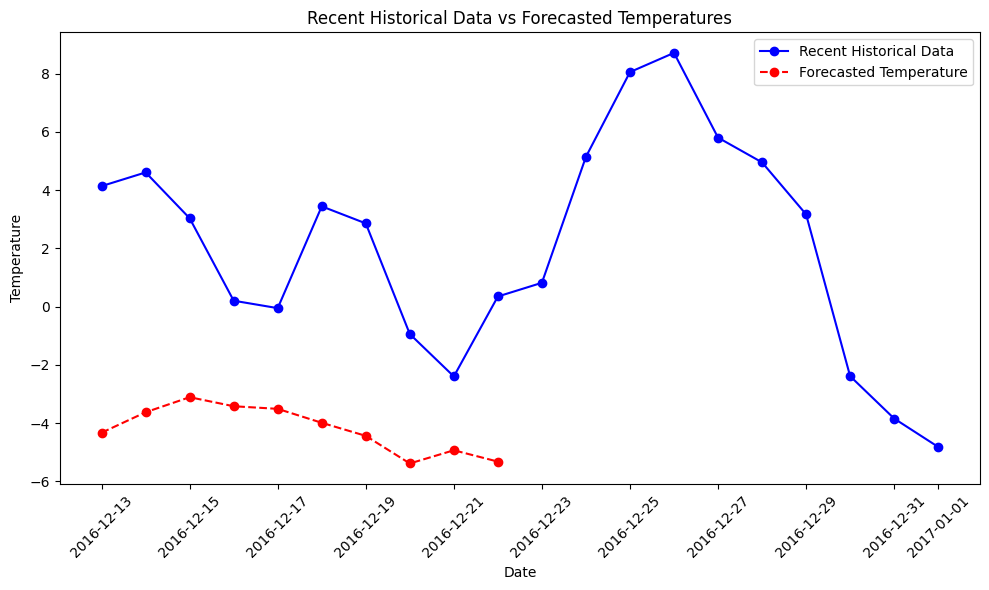

In [ ]:
#Get the last 20 days of data from the end of your dataset
recent_data = climate_daily['Temp'].values[-input_length:]

# Reshape the recent data to be [samples, time steps, features]
recent_data_reshaped = recent_data.reshape((1, input_length, 1))

# Make predictions for the first 10 days of January 2017
forecast = model.predict(recent_data_reshaped).flatten()
print(f'Forecast for the first 10 days of January 2017: {forecast}')

# Dates for the forecasted period (next 10 days)
forecast_dates = pd.date_range(start=climate_daily.index[-input_length], periods=output_length)

# Dates for the recent historical data used for forecasting
recent_dates = pd.date_range(start=climate_daily.index[-input_length], periods=input_length)

# Plot recent historical data and forecasted temperatures
plt.figure(figsize=(10, 6))
plt.plot(recent_dates, recent_data, marker='o', linestyle='-', color='b', label='Recent Historical Data')
plt.plot(forecast_dates, forecast, marker='o', linestyle='--', color='r', label='Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Recent Historical Data vs Forecasted Temperatures')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
print(forecast_dates)

DatetimeIndex(['2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', freq='D')


# *Forecasting Temperature for future data which is not present in the dataset using the trained model*

1/1 [==============================] - 0s 82ms/step
Forecast for the first 10 days of January 2017: [-4.331729  -3.6294913 -3.1128387 -3.4235811 -3.5130737 -3.9917583
 -4.4405136 -5.388023  -4.935179  -5.3245378]


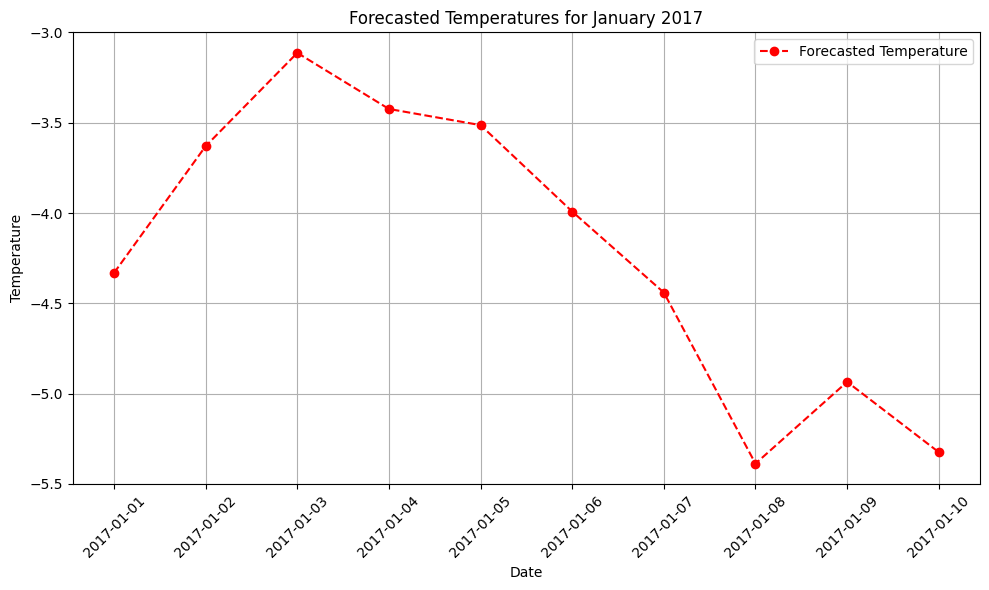

In [ ]:
 #Get the last 20 days of data from the end of your dataset
recent_data = climate_daily['Temp'].values[-input_length:]

# Reshape the recent data to be [samples, time steps, features]
recent_data_reshaped = recent_data.reshape((1, input_length, 1))

# Make predictions for the first 10 days of January 2017
forecast = model.predict(recent_data_reshaped).flatten()
print(f'Forecast for the first 10 days of January 2017: {forecast}')

# Dates for the forecasted period (next 10 days)
forecast_dates = pd.date_range(start='2017-01-01', periods=output_length, freq='D')

# Plot forecasted temperatures
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, forecast, marker='o', linestyle='--', color='r', label='Forecasted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasted Temperatures for January 2017')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()